Соревнование: https://www.kaggle.com/c/chinese-characters-2020


In [ ]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDClassifier
import time
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pylab
from matplotlib import cm
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
import torch
import torchvision
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence
from google.colab import files
from zipfile import ZipFile
from functools import partial
from dataclasses import dataclass
from collections import OrderedDict
from zipfile import ZipFile as zip
from torchsummary import summary
from typing import Type, Any, Callable, Union, List, Optional
from torch import Tensor

 
import seaborn as sns
sns.set(style="darkgrid")
 
%matplotlib inline

In [ ]:
!pip install kaggle

In [ ]:
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c chinese-characters-2020

In [ ]:
!ls

In [ ]:
zip = ZipFile('train.npy.zip')
zip.extractall()
zip = ZipFile('test.npy.zip')
zip.extractall()

In [ ]:
train = np.load('train.npy', allow_pickle=True)

In [ ]:
test = np.load('test.npy', allow_pickle=True)

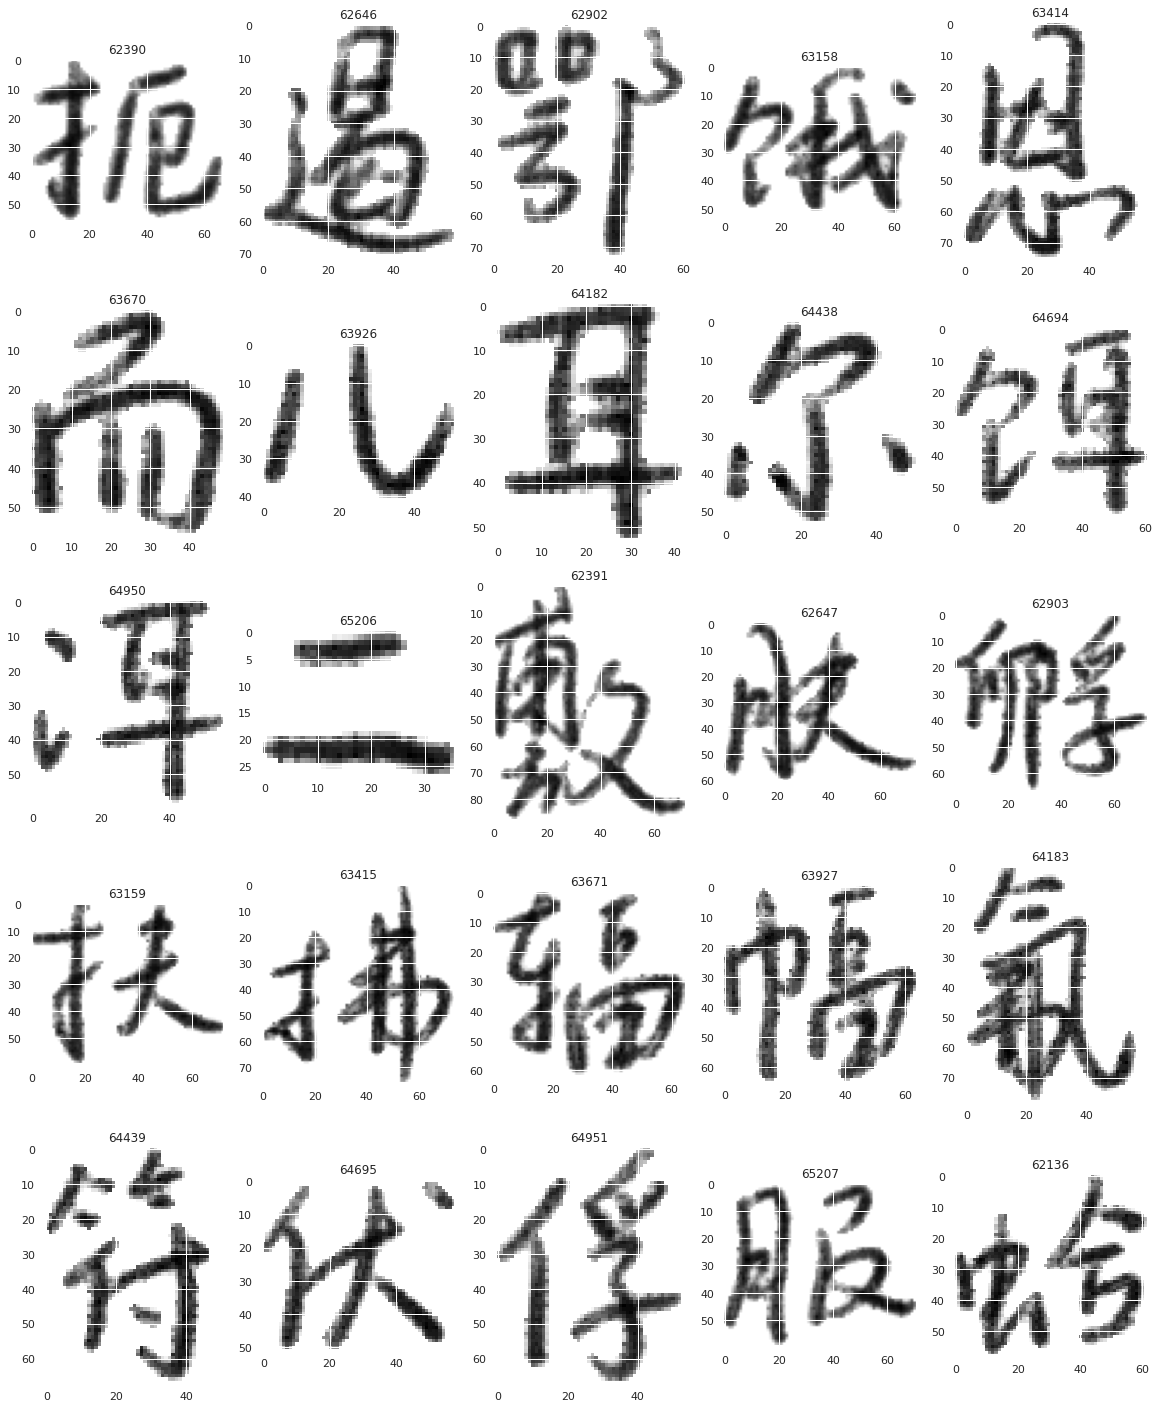

In [ ]:
width = 5
height = 5

plt.figure(figsize=(20, 25))
for n, (image, tag) in enumerate(train, 1):
    if n > width * height:
        break
    plt.subplot(height, width, n)
    plt.title(tag)
    plt.imshow(image, cmap='gray')

In [ ]:
train_data = train[:, 0]
train_labels = train[:, 1]

In [ ]:
compose = transforms.Compose([
                              transforms.ToPILImage(),
                              transforms.Resize((64, 64)),
                              transforms.ToTensor()
                              ])

In [ ]:
for i in range(train_data.shape[0]):
    train_data[i] = torch.Tensor(train_data[i])
    train_data[i] = compose(train_data[i])

In [ ]:
train_data = pad_sequence(train_data)

In [ ]:
np.max(train_labels)

65238

In [ ]:
np.min(train_labels)

62136

In [ ]:
np.unique(train_labels).shape

(500,)

Хотим, чтобы индексы были от 1 до 500

In [ ]:
d_l = np.unique(train_labels)
dict_l = {}
for i in range(len(d_l)):
    dict_l.update({d_l[i] : i})

new_train_labels = []
for i in range(train_labels.shape[0]):
    new_train_labels.append(dict_l[train_labels[i]])

new_train_labels = torch.Tensor(new_train_labels)

In [ ]:
new_train_labels = new_train_labels.long()

In [ ]:
train_data = train_data.resize(166708, 1, 64, 64)

In [ ]:
tr_data = torch.utils.data.TensorDataset(train_data, new_train_labels)

In [ ]:
train_dataset, test_dataset = torch.utils.data.random_split(tr_data, [130000, 36708])

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

In [ ]:
class ConvNet(nn.Module): 
    def __init__(self): 
        super(ConvNet, self).__init__() 
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64)) 
    
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2), 
            nn.ReLU())
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(128))
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU()) 
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3),
            nn.BatchNorm2d(256))
        
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=5, stride=1, padding=2), 
            nn.ReLU())
        
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.BatchNorm2d(128))
         
        self.fc1 = nn.Linear(4 * 4 * 128, 500) 

    def forward(self, x): 
        out = self.layer1(x) 
        out = self.layer2(out) 
        out = self.layer3(out) 
        out = self.layer4(out) 
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = out.reshape(out.size(0), -1)  
        out = self.fc1(out) 
        return out

In [ ]:
model = resnet34()
summary(model.cuda(), (1, 64, 64))

In [ ]:
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda')
optimizer = torch.optim.Adam(model.cuda().parameters())

In [ ]:
total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(10):
    for i, (images, labels) in enumerate(tqdm(train_loader)):
        #print(labels)
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 20, 30, i + 1, total_step, loss.item(),
                          (correct / total) * 100))
      

  5%|▌         | 102/2032 [00:06<02:04, 15.46it/s]

Epoch [20/30], Step [100/2032], Loss: 0.1102, Accuracy: 93.75%


 10%|▉         | 202/2032 [00:13<01:58, 15.44it/s]

Epoch [20/30], Step [200/2032], Loss: 0.1212, Accuracy: 96.88%


 15%|█▍        | 302/2032 [00:19<01:53, 15.29it/s]

Epoch [20/30], Step [300/2032], Loss: 0.0929, Accuracy: 96.88%


 20%|█▉        | 402/2032 [00:26<01:46, 15.24it/s]

Epoch [20/30], Step [400/2032], Loss: 0.0045, Accuracy: 100.00%


 25%|██▍       | 502/2032 [00:32<01:41, 15.12it/s]

Epoch [20/30], Step [500/2032], Loss: 0.0729, Accuracy: 98.44%


 30%|██▉       | 602/2032 [00:39<01:35, 15.01it/s]

Epoch [20/30], Step [600/2032], Loss: 0.0014, Accuracy: 100.00%


 35%|███▍      | 702/2032 [00:45<01:28, 14.96it/s]

Epoch [20/30], Step [700/2032], Loss: 0.1562, Accuracy: 96.88%


 39%|███▉      | 802/2032 [00:52<01:23, 14.80it/s]

Epoch [20/30], Step [800/2032], Loss: 0.0017, Accuracy: 100.00%


 44%|████▍     | 902/2032 [00:59<01:15, 15.05it/s]

Epoch [20/30], Step [900/2032], Loss: 0.0178, Accuracy: 100.00%


 49%|████▉     | 1002/2032 [01:06<01:08, 15.11it/s]

Epoch [20/30], Step [1000/2032], Loss: 0.0002, Accuracy: 100.00%


 54%|█████▍    | 1102/2032 [01:12<01:01, 15.07it/s]

Epoch [20/30], Step [1100/2032], Loss: 0.0049, Accuracy: 100.00%


 59%|█████▉    | 1202/2032 [01:19<00:55, 14.91it/s]

Epoch [20/30], Step [1200/2032], Loss: 0.0002, Accuracy: 100.00%


 64%|██████▍   | 1302/2032 [01:25<00:48, 15.08it/s]

Epoch [20/30], Step [1300/2032], Loss: 0.0366, Accuracy: 98.44%


 69%|██████▉   | 1402/2032 [01:32<00:41, 15.07it/s]

Epoch [20/30], Step [1400/2032], Loss: 0.0043, Accuracy: 100.00%


 74%|███████▍  | 1502/2032 [01:39<00:35, 15.08it/s]

Epoch [20/30], Step [1500/2032], Loss: 0.0011, Accuracy: 100.00%


 79%|███████▉  | 1602/2032 [01:45<00:28, 15.14it/s]

Epoch [20/30], Step [1600/2032], Loss: 0.0048, Accuracy: 100.00%


 84%|████████▍ | 1702/2032 [01:52<00:21, 15.09it/s]

Epoch [20/30], Step [1700/2032], Loss: 0.0071, Accuracy: 100.00%


 89%|████████▊ | 1802/2032 [01:58<00:15, 15.06it/s]

Epoch [20/30], Step [1800/2032], Loss: 0.0081, Accuracy: 100.00%


 94%|█████████▎| 1902/2032 [02:05<00:08, 15.18it/s]

Epoch [20/30], Step [1900/2032], Loss: 0.0006, Accuracy: 100.00%


 99%|█████████▊| 2002/2032 [02:12<00:01, 15.03it/s]

Epoch [20/30], Step [2000/2032], Loss: 0.0001, Accuracy: 100.00%


  5%|▌         | 102/2032 [00:06<02:08, 15.02it/s]

Epoch [21/30], Step [100/2032], Loss: 0.0004, Accuracy: 100.00%


 10%|▉         | 202/2032 [00:13<02:01, 15.07it/s]

Epoch [21/30], Step [200/2032], Loss: 0.0001, Accuracy: 100.00%


 15%|█▍        | 302/2032 [00:20<01:55, 14.93it/s]

Epoch [21/30], Step [300/2032], Loss: 0.0072, Accuracy: 100.00%


 20%|█▉        | 402/2032 [00:26<01:48, 15.03it/s]

Epoch [21/30], Step [400/2032], Loss: 0.0004, Accuracy: 100.00%


 25%|██▍       | 502/2032 [00:33<01:41, 15.14it/s]

Epoch [21/30], Step [500/2032], Loss: 0.0001, Accuracy: 100.00%


 30%|██▉       | 602/2032 [00:39<01:34, 15.07it/s]

Epoch [21/30], Step [600/2032], Loss: 0.0559, Accuracy: 98.44%


 35%|███▍      | 702/2032 [00:46<01:28, 15.06it/s]

Epoch [21/30], Step [700/2032], Loss: 0.0010, Accuracy: 100.00%


 39%|███▉      | 802/2032 [00:53<01:21, 15.13it/s]

Epoch [21/30], Step [800/2032], Loss: 0.0073, Accuracy: 100.00%


 44%|████▍     | 902/2032 [00:59<01:14, 15.14it/s]

Epoch [21/30], Step [900/2032], Loss: 0.0002, Accuracy: 100.00%


 49%|████▉     | 1002/2032 [01:06<01:07, 15.23it/s]

Epoch [21/30], Step [1000/2032], Loss: 0.0068, Accuracy: 100.00%


 54%|█████▍    | 1102/2032 [01:13<01:01, 15.10it/s]

Epoch [21/30], Step [1100/2032], Loss: 0.0288, Accuracy: 98.44%


 59%|█████▉    | 1202/2032 [01:19<00:54, 15.20it/s]

Epoch [21/30], Step [1200/2032], Loss: 0.0098, Accuracy: 100.00%


 64%|██████▍   | 1302/2032 [01:26<00:48, 15.00it/s]

Epoch [21/30], Step [1300/2032], Loss: 0.0179, Accuracy: 98.44%


 69%|██████▉   | 1402/2032 [01:32<00:42, 14.89it/s]

Epoch [21/30], Step [1400/2032], Loss: 0.0015, Accuracy: 100.00%


 74%|███████▍  | 1502/2032 [01:39<00:34, 15.20it/s]

Epoch [21/30], Step [1500/2032], Loss: 0.0352, Accuracy: 98.44%


 79%|███████▉  | 1602/2032 [01:46<00:28, 15.20it/s]

Epoch [21/30], Step [1600/2032], Loss: 0.0047, Accuracy: 100.00%


 84%|████████▍ | 1702/2032 [01:52<00:21, 15.06it/s]

Epoch [21/30], Step [1700/2032], Loss: 0.0018, Accuracy: 100.00%


 89%|████████▊ | 1802/2032 [01:59<00:15, 15.18it/s]

Epoch [21/30], Step [1800/2032], Loss: 0.0048, Accuracy: 100.00%


 94%|█████████▎| 1902/2032 [02:06<00:08, 15.14it/s]

Epoch [21/30], Step [1900/2032], Loss: 0.0082, Accuracy: 100.00%


 99%|█████████▊| 2002/2032 [02:12<00:01, 15.08it/s]

Epoch [21/30], Step [2000/2032], Loss: 0.0025, Accuracy: 100.00%


  5%|▌         | 102/2032 [00:06<02:07, 15.13it/s]

Epoch [22/30], Step [100/2032], Loss: 0.0044, Accuracy: 100.00%


 10%|▉         | 202/2032 [00:13<02:00, 15.21it/s]

Epoch [22/30], Step [200/2032], Loss: 0.0668, Accuracy: 98.44%


 15%|█▍        | 302/2032 [00:19<01:55, 15.02it/s]

Epoch [22/30], Step [300/2032], Loss: 0.0029, Accuracy: 100.00%


 20%|█▉        | 402/2032 [00:26<01:46, 15.24it/s]

Epoch [22/30], Step [400/2032], Loss: 0.0018, Accuracy: 100.00%


 25%|██▍       | 502/2032 [00:33<01:41, 15.05it/s]

Epoch [22/30], Step [500/2032], Loss: 0.0007, Accuracy: 100.00%


 30%|██▉       | 602/2032 [00:39<01:34, 15.06it/s]

Epoch [22/30], Step [600/2032], Loss: 0.0036, Accuracy: 100.00%


 35%|███▍      | 702/2032 [00:46<01:27, 15.12it/s]

Epoch [22/30], Step [700/2032], Loss: 0.0002, Accuracy: 100.00%


 39%|███▉      | 802/2032 [00:53<01:21, 15.13it/s]

Epoch [22/30], Step [800/2032], Loss: 0.0405, Accuracy: 98.44%


 44%|████▍     | 902/2032 [00:59<01:14, 15.20it/s]

Epoch [22/30], Step [900/2032], Loss: 0.0004, Accuracy: 100.00%


 49%|████▉     | 1002/2032 [01:06<01:08, 14.96it/s]

Epoch [22/30], Step [1000/2032], Loss: 0.0018, Accuracy: 100.00%


 54%|█████▍    | 1102/2032 [01:12<01:01, 15.16it/s]

Epoch [22/30], Step [1100/2032], Loss: 0.0029, Accuracy: 100.00%


 59%|█████▉    | 1202/2032 [01:19<00:54, 15.16it/s]

Epoch [22/30], Step [1200/2032], Loss: 0.0001, Accuracy: 100.00%


 64%|██████▍   | 1302/2032 [01:26<00:47, 15.25it/s]

Epoch [22/30], Step [1300/2032], Loss: 0.0004, Accuracy: 100.00%


 69%|██████▉   | 1402/2032 [01:32<00:41, 15.19it/s]

Epoch [22/30], Step [1400/2032], Loss: 0.0039, Accuracy: 100.00%


 74%|███████▍  | 1502/2032 [01:39<00:35, 15.08it/s]

Epoch [22/30], Step [1500/2032], Loss: 0.0186, Accuracy: 98.44%


 79%|███████▉  | 1602/2032 [01:46<00:28, 14.97it/s]

Epoch [22/30], Step [1600/2032], Loss: 0.0441, Accuracy: 98.44%


 84%|████████▍ | 1702/2032 [01:52<00:21, 15.16it/s]

Epoch [22/30], Step [1700/2032], Loss: 0.0192, Accuracy: 98.44%


 89%|████████▊ | 1802/2032 [01:59<00:15, 15.10it/s]

Epoch [22/30], Step [1800/2032], Loss: 0.0007, Accuracy: 100.00%


 94%|█████████▎| 1902/2032 [02:05<00:08, 15.08it/s]

Epoch [22/30], Step [1900/2032], Loss: 0.0156, Accuracy: 98.44%


 99%|█████████▊| 2002/2032 [02:12<00:01, 15.27it/s]

Epoch [22/30], Step [2000/2032], Loss: 0.0173, Accuracy: 100.00%


  5%|▌         | 102/2032 [00:06<02:09, 14.95it/s]

Epoch [23/30], Step [100/2032], Loss: 0.0021, Accuracy: 100.00%


 10%|▉         | 202/2032 [00:13<02:02, 15.00it/s]

Epoch [23/30], Step [200/2032], Loss: 0.0005, Accuracy: 100.00%


 15%|█▍        | 302/2032 [00:20<01:54, 15.12it/s]

Epoch [23/30], Step [300/2032], Loss: 0.0001, Accuracy: 100.00%


 20%|█▉        | 402/2032 [00:26<01:48, 14.98it/s]

Epoch [23/30], Step [400/2032], Loss: 0.0003, Accuracy: 100.00%


 25%|██▍       | 502/2032 [00:33<01:40, 15.18it/s]

Epoch [23/30], Step [500/2032], Loss: 0.0707, Accuracy: 95.31%


 30%|██▉       | 602/2032 [00:39<01:35, 15.04it/s]

Epoch [23/30], Step [600/2032], Loss: 0.0059, Accuracy: 100.00%


 35%|███▍      | 702/2032 [00:46<01:27, 15.18it/s]

Epoch [23/30], Step [700/2032], Loss: 0.0018, Accuracy: 100.00%


 39%|███▉      | 802/2032 [00:53<01:22, 14.99it/s]

Epoch [23/30], Step [800/2032], Loss: 0.0612, Accuracy: 96.88%


 44%|████▍     | 902/2032 [00:59<01:14, 15.20it/s]

Epoch [23/30], Step [900/2032], Loss: 0.0404, Accuracy: 98.44%


 48%|████▊     | 966/2032 [01:04<01:10, 15.18it/s]

In [ ]:
np.mean(acc_list)

In [ ]:
torch.save(model.state_dict(), 'best_model.pth')

In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in val_loader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 36708 validation images: {} %'.format((correct / total) * 100))


Test Accuracy of the model on the 36708 validation images: 97.15593331153973 %


In [ ]:
 for i in range(test.shape[0]):
    test[i] = torch.Tensor(test[i])
    test[i] = compose(test[i])

In [ ]:
test = pad_sequence(test)

In [ ]:
test.shape

torch.Size([1, 41428, 64, 64])

In [ ]:
test = test.resize(41428, 1, 64, 64)

/usr/local/lib/python3.6/dist-packages/torch/tensor.py:447: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [ ]:
test_loader = torch.utils.data.DataLoader(test, batch_size=1)

In [ ]:
pred = []
for img in test_loader:
    img = img.cuda()
    outputs = model(img)
    _, predicted = torch.max(outputs.data, 1)
    pred.append(predicted)

In [ ]:
num_res = []
for i in range(len(pred)):
    num_res.append(int(pred[i][0]))

In [ ]:
k = dict_l.copy()

In [ ]:
l = {i:j for j, i in k.items()}

In [ ]:
for i in range(len(num_res)):
    num_res[i] = l[num_res[i]]

In [ ]:
result = pd.DataFrame()

In [ ]:
result['Category'] = num_res

In [ ]:
result.index = np.arange(1, 41429)

In [ ]:
result.index.names = ['Id']

In [ ]:
result

,Category
Id,
1,62148
2,62404
3,62660
4,62916
5,63172
...,...
41424,64202
41425,64458
41426,64711


In [ ]:
result.to_csv('res4.csv')
files.download("res4.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>